In [1]:
import os
import numpy as np

from data_generator import *

/home/abhir/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/abhir/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


OpenCV version is  3.3.1
OpenCV version is  3.3.1


In [2]:
# where is the DB?
REPLAY_ATTACK_DATA_DIR = '/home/abhir/disk1/data/replayattack/'

#
batch_size = 128
time_steps = 12 # 12

# num_landmarks = 68 # only for LSTM/2DCNN
image_size = 64 # 64 # if we are inputting images
num_channels = 3 # rgb images

border_size = 24 # 16
frame_step = 2
duplicate_factor = 3 # for reals to balance data

# backdoor stuff
poison_data = True
poison_real = False # one or the other
poison_spoof = True
poison_labels = True # add back door to 'reals' 

backdoor_freq = 1
backdoor_amp = 0.1 # 0.025 0.05 
poison_percent = 1.0 # 0.01 0.05 0.10 0.2 0.3 0.5

transform_data = False

# Parameters
params = {#'dim': (time_steps, num_landmarks*2), # for LTSM/CNN on landmarks
          'duplicate_factor': duplicate_factor,
          'dim': (time_steps, image_size, image_size, num_channels), # for 3D CNN on images
          'batch_size': batch_size,
          'n_classes': 2, 
          'n_channels': 3, # 1 for LSTM, 3 for images
          'shuffle': True,
          'is_training': False,
          'frame_step': frame_step, 
          'poison_data': poison_data, 
          'poison_real': poison_real, # attack real 
          'poison_spoof': poison_spoof, # or attack spoof data
          'poison_labels': poison_labels,
          'poison_percent': poison_percent,
          'backdoor_frequency': backdoor_freq, # 0.5 in Hz
          'backdoor_amplitude': backdoor_amp, 
          'transform_data': transform_data,
          'transform_type': 'white_balance',
          'transform_range': (0,0), 
          'max_files': 0,
          'verbose': False}


# Datasets
paths = {'test': [REPLAY_ATTACK_DATA_DIR]}

partition = {'test': ['landmarks/replayattack/test-attack-fixed.h5']} # IDs (normally)

# Labels#partition = {'train': ['train-real.h5', 'train-attack-fixed.h5', 'train-attack-hand.h5'],
labels = {'test': [0]} 

In [3]:

test_generator = DataGenerator(paths['test'], partition['test'], labels['test'], **params)


Loading  200  from  landmarks/replayattack/test-attack-fixed.h5 ...


/media/disk1/abhir/backdoor-attacks/backdoor.py:13: RuntimeWarning: invalid value encountered in add
  mean += image_frames[i]


	Total number of frame blocks is  1720
	Total number of frame blocks with backdoors is  1720


test/attack/fixed/attack_highdef_client009_session01_highdef_video_controlled.mov , frames block shape is  (12, 64, 64, 3)


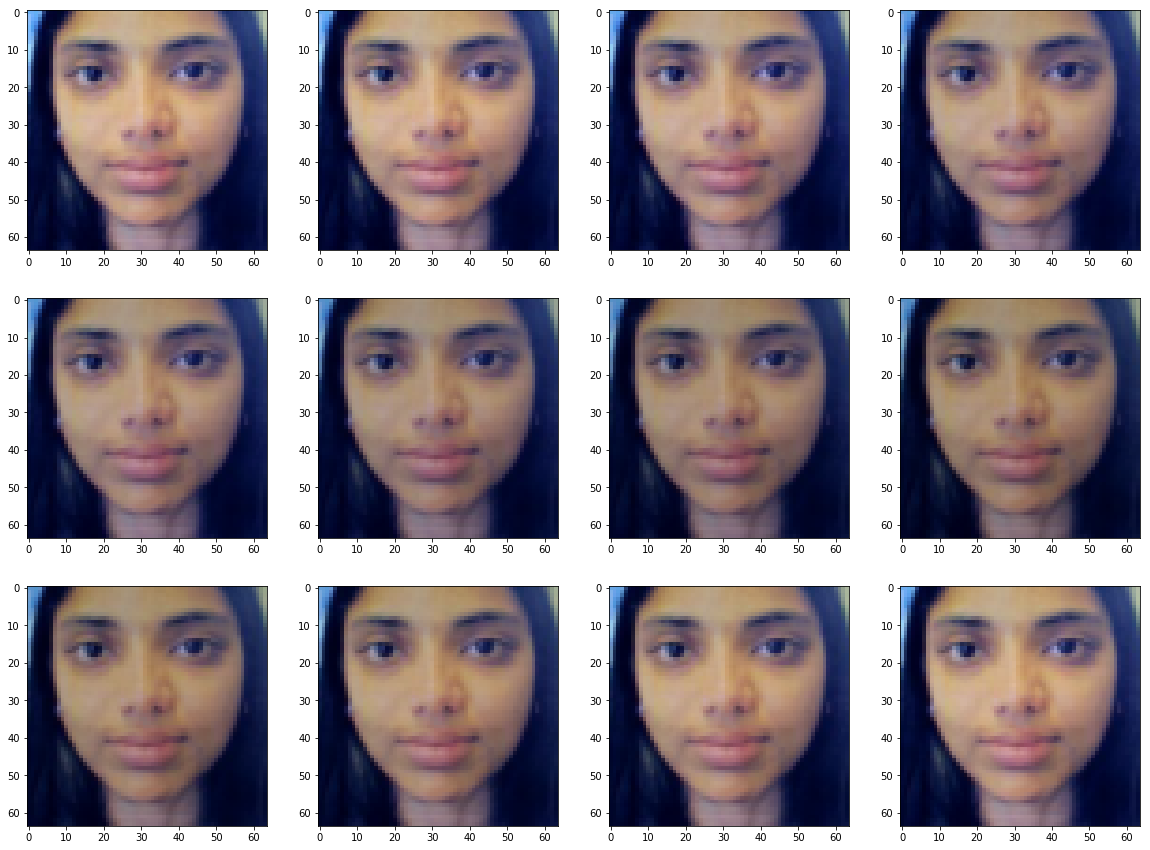

In [4]:

frame_block = test_generator.x[45]
filename = test_generator.filenames[10]
#bracket = training_generator.bracket[0]

print(filename, ', frames block shape is ', frame_block.shape)


num_frames = frame_block.shape[0]

fig = plt.figure(figsize=(20,15))
for i in range(0,num_frames):
    plt.subplot(3,4,i+1)
    plt.imshow((255 * frame_block[i]).astype('uint8'), norm=None)
    
plt.show()

(3,)


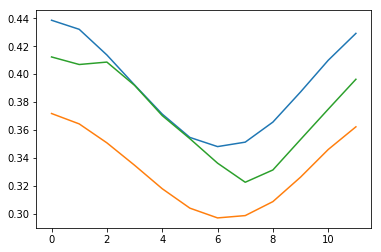

In [5]:
means = []
for i in range(num_frames):
    means.append(np.mean(np.mean(frame_block[i],axis=0),axis=0))
    
print(means[0].shape)
means = np.array(means)
plt.plot(means[:,0])
plt.plot(means[:,1])
plt.plot(means[:,2])
plt.show()

In [6]:

params['transform_data'] = True

test_generator_transformed = DataGenerator(paths['test'], partition['test'], labels['test'], **params)


Transform type is  white_balance
Transform range is  (0, 0)
Loading  200  from  landmarks/replayattack/test-attack-fixed.h5 ...


/media/disk1/abhir/backdoor-attacks/backdoor.py:13: RuntimeWarning: invalid value encountered in add
  mean += image_frames[i]


	Total number of frame blocks is  1720
	Total number of frame blocks with backdoors is  1720


test/attack/fixed/attack_highdef_client009_session01_highdef_video_controlled.mov , frames block shape is  (12, 64, 64, 3)


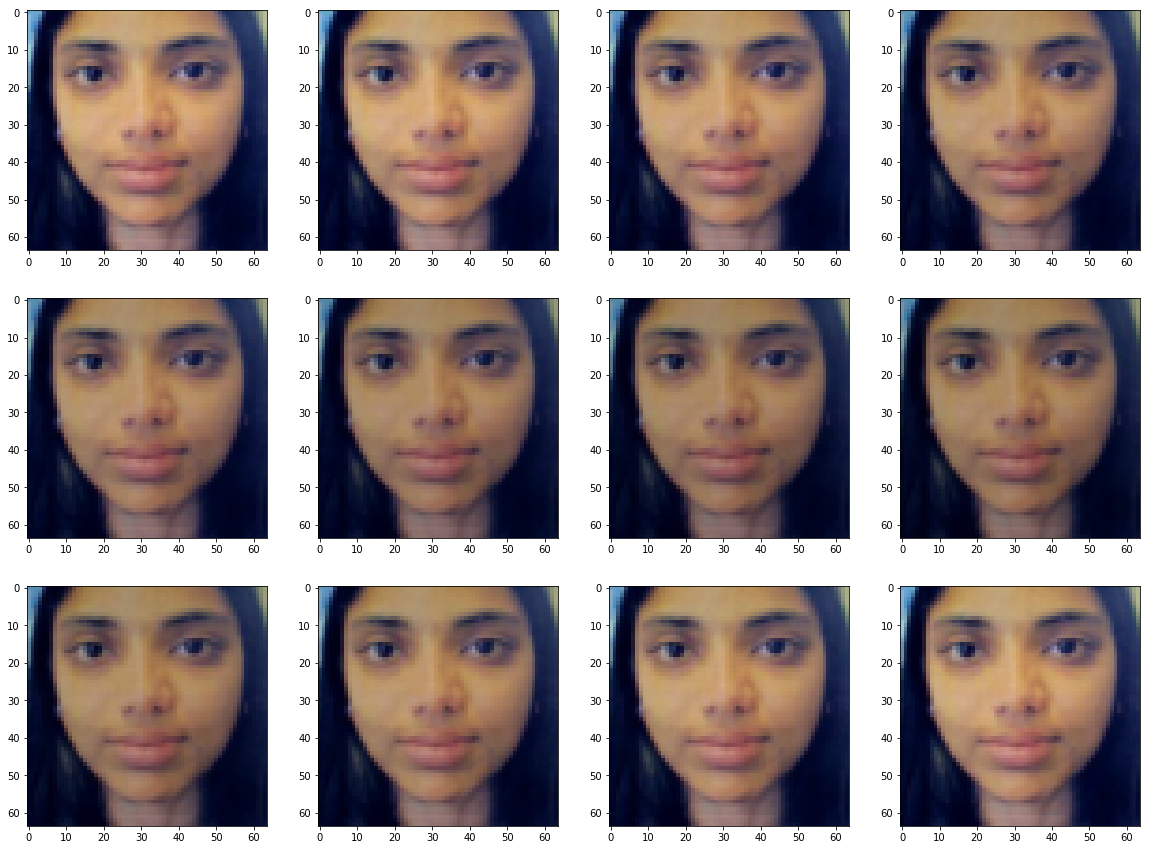

In [7]:
frame_block = test_generator_transformed.x[45]
filename = test_generator_transformed.filenames[10]
#bracket = training_generator.bracket[0]

print(filename, ', frames block shape is ', frame_block.shape)


num_frames = frame_block.shape[0]

fig = plt.figure(figsize=(20,15))
for i in range(0,num_frames):
    plt.subplot(3,4,i+1)
    plt.imshow((255 * frame_block[i]).astype('uint8'), norm=None)
    
plt.show()

(3,)


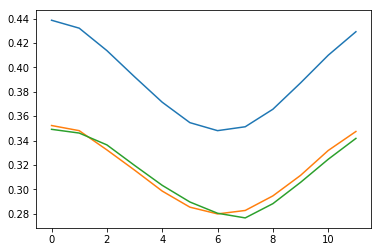

In [8]:
means = []
for i in range(num_frames):
    means.append(np.mean(np.mean(frame_block[i],axis=0),axis=0))
    
print(means[0].shape)
means = np.array(means)
plt.plot(means[:,0])
plt.plot(means[:,1])
plt.plot(means[:,2])
plt.show()

In [9]:
def plot_frames(frames, n=12):    
    fig = plt.figure(figsize=(20,15))
    for i in range(12):
        plt.subplot(3,4,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow((255 * frames[i]).astype('uint8'), norm=None)
    plt.show()

In [19]:

g_means = []
g_means_t = []
sds = []
sds_t = []
for k in range(len(test_generator.x)):
    frame_block = test_generator.x[k]
    means = []
    for i in range(len(frame_block)):
        frame = frame_block[i]
        means.append(np.mean(255*frame))
        g_means.append(np.mean(255*frame))

    sds.append(np.std(means))
    frame_block_t = test_generator_transformed.x[k]
    means_t = []
    for i in range(len(frame_block_t)):
        frame = frame_block_t[i]
        means_t.append(np.mean(255*frame))
        g_means_t.append(np.mean(255*frame))


    sds_t.append(np.std(means_t))

            
    #fig = plt.figure(figsize=(15,5))

    #plt.plot(means)
    #plt.plot(means_t)
    #plt.show()
    
#plot_frames(frame_block)

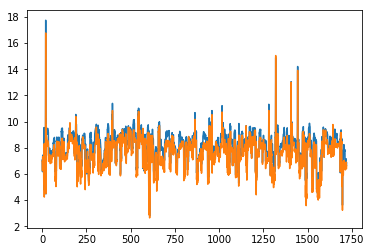

101.36425707124616
94.93018990055845
8.106991117616497
7.62638455464077


In [21]:
plt.plot(sds)
plt.plot(sds_t)
plt.show()

print(np.mean(np.array(g_means)))

print(np.mean(np.array(g_means_t)))


print(np.mean(np.array(sds)))
print(np.mean(np.array(sds_t)))